In [226]:
%load_ext autoreload
%autoreload 2
from datasets import load_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from scipy.sparse import hstack
import nltk as nltk
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import numpy as np
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from IPython.display import clear_output
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adnan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adnan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\adnan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [227]:
# Loading files
train_files = [
    'data/FiQA_ABSA_task1/task1_headline_ABSA_train.json',
    'data/FiQA_ABSA_task1/task1_post_ABSA_train.json'
]

In [228]:
## Loading data from JSON
import json

def load_fiqa_sa_from_json(json_files):
    train_text = []
    train_labels = []

    for file in json_files:
        with open(file, 'r', encoding='UTF-8') as handle:
            dataf = json.load(handle)
        dataf_text = [dataf[k]["sentence"] for k in dataf.keys()]
        train_text.extend(dataf_text)
        dataf_labels = [float(dataf[k]["info"][0]["sentiment_score"]) for k in dataf.keys()]
        train_labels.extend(dataf_labels)
    train_text = np.array(train_text)
    train_labels = np.array(train_labels)
    return train_text, train_labels


def threshold_scores(scores):
    """
    Convert sentiment scores to discrete labels.
    0 = negative.
    1 = neutral.
    2 = positive.
    """
    labels = []
    for score in scores:
        if score < -0.2:
            labels.append(0)
        elif score > 0.2:
            labels.append(2)
        else:
            labels.append(1)
            
    return np.array(labels)


all_text, all_labels = load_fiqa_sa_from_json(train_files)
    
print(f'Number of instances: {len(all_text)}')
print(f'Number of labels: {len(all_labels)}')

all_labels = threshold_scores(all_labels)
print(f'Number of negative labels: {np.sum(all_labels==0)}')
print(f'Number of neutral labels: {np.sum(all_labels==1)}')
print(f'Number of positive labels: {np.sum(all_labels==2)}')

Number of instances: 1111
Number of labels: 1111
Number of negative labels: 310
Number of neutral labels: 195
Number of positive labels: 606


In [229]:
# Split the data into training, validation, testing sets.

from sklearn.model_selection import train_test_split

# Split test data from training data
train_tweets, test_tweets, train_labels, test_labels = train_test_split(
    all_text, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels
)

# Split validation data from training data
train_tweets, val_documents, train_labels, val_labels = train_test_split(
    train_tweets, 
    train_labels, 
    test_size=0.2, 
    stratify=train_labels
)

print(f'Number of training instances = {len(train_tweets)}')
print(f'Number of validation instances = {len(val_documents)}')
print(f'Number of test instances = {len(test_tweets)}')


Number of training instances = 710
Number of validation instances = 178
Number of test instances = 223


In [230]:
# Print example tweet
print(f'What does one instance look like from the training set? \n\n{train_tweets[234]}')
print(f'...and here is its corresponding label \n\n{train_labels[234]}')

What does one instance look like from the training set? 

$FREE Ha Heeeeeere comes the pump! So glad I picked up 9K end of day! Get ready for the bull ride!
...and here is its corresponding label 

2


# 1. Preprocessing using  lemmatization
We create a lemmatizer tokenizer that reduces words to their root forms. This reduces the vocabulary size.

In [231]:
# We create a lemmaTokenizer class that applies lemmatization when tokenizing.
class LemmaTokenizer(object):
    
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        
    def __call__(self, tweets):
        return [self.wnl.lemmatize(self.wnl.lemmatize(self.wnl.lemmatize(tok, pos='n'), pos='v'), pos='a') for tok in word_tokenize(tweets)]
    

# 2.1 Using bi-grams + unigrams as feature
We apply our tokenizer and set it to allow ngram features (both unigrams and bigrams). 

In [232]:
vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), ngram_range=(1,2))
vectorizer.fit(train_tweets)
X_train = vectorizer.transform(train_tweets)
X_val = vectorizer.transform(val_documents)
X_test_tweets = vectorizer.transform(test_tweets)
# Let's look at some of the features.
print(list(vectorizer.vocabulary_)[:10])

C:\Users\adnan\anaconda3\envs\data_analytics\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['upside', 'move', 'in', 'the', 'volatile', '#', 'mine', 'sector', ',', 'send']


In [233]:
# Checking full vocabulary size:
print(f' Full vocabulary size: {len(vectorizer.vocabulary_)}')
vocabulary = vectorizer.vocabulary_

 Full vocabulary size: 10603


              precision    recall  f1-score   support

           0       0.64      0.46      0.53        50
           1       1.00      0.10      0.18        31
           2       0.64      0.92      0.75        97

    accuracy                           0.65       178
   macro avg       0.76      0.49      0.49       178
weighted avg       0.70      0.65      0.59       178



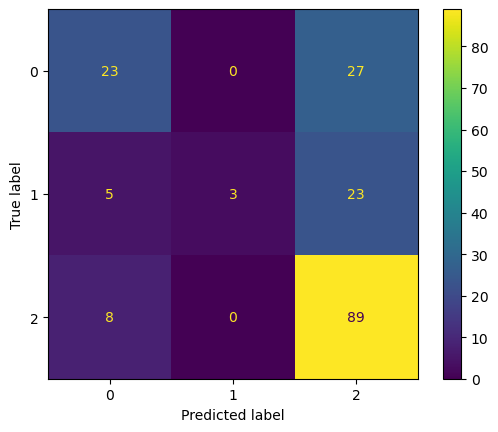

In [234]:
# Now let's fit our data to the model.
classifier = LogisticRegression()
classifier.fit(X_train, train_labels)
y_val_pred = classifier.predict(X_val)
cm = confusion_matrix(val_labels, y_val_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
print(classification_report(val_labels, y_val_pred))

# Using POS-NEG lexicon features

In [236]:
# instantiate analyzer
analyser = SentimentIntensityAnalyzer()
# fetch vocabulary
vocabulary = vectorizer.vocabulary_
# create empy holders for lexicon scores.
lexicon_pos_scores = np.zeros((1, len(vocabulary)))
lexicon_neg_scores = np.zeros((1, len(vocabulary)))

for i, term in enumerate(vocabulary):
    if term in analyser.lexicon and analyser.lexicon[term] > 0:
        lexicon_pos_scores[0, i] = 1
    elif term in analyser.lexicon and analyser.lexicon[term] < 0:
        lexicon_neg_scores[0, i] = 1

In [237]:
# This enables us to get the total positive and total negative counts for each set:
lexicon_pos_train = np.sum(X_train.multiply(lexicon_pos_scores), axis=1)
lexicon_pos_val = np.sum(X_val.multiply(lexicon_pos_scores), axis=1)
lexicon_pos_test = np.sum(X_test_tweets.multiply(lexicon_pos_scores), axis=1)

lexicon_neg_train = np.sum(X_train.multiply(lexicon_neg_scores), axis=1)
lexicon_neg_val = np.sum(X_val.multiply(lexicon_neg_scores), axis=1)
lexicon_neg_test = np.sum(X_test_tweets.multiply(lexicon_neg_scores), axis=1)

In [238]:
X_train = hstack((X_train, lexicon_pos_train, lexicon_neg_train))
X_val = hstack((X_val, lexicon_pos_val, lexicon_neg_val))
X_test_tweets = hstack((X_test_tweets, lexicon_pos_test, lexicon_neg_test))

              precision    recall  f1-score   support

           0       0.67      0.40      0.50        50
           1       1.00      0.10      0.18        31
           2       0.63      0.94      0.75        97

    accuracy                           0.64       178
   macro avg       0.76      0.48      0.48       178
weighted avg       0.70      0.64      0.58       178



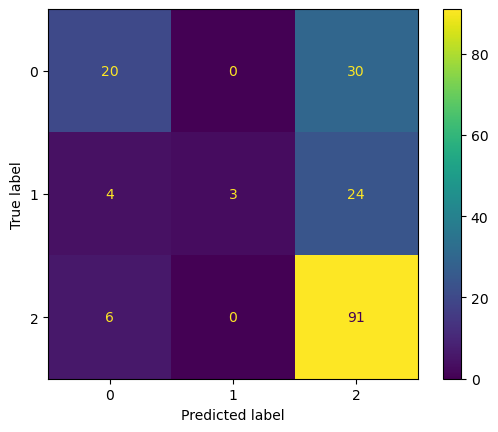

In [239]:
classifier = LogisticRegression()
classifier.fit(X_train, train_labels)
y_val_pred = classifier.predict(X_val)
# Checking performance
cm = confusion_matrix(val_labels, y_val_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
print(classification_report(val_labels, y_val_pred))

In [240]:
# Key part is investigating the errors by looking at the actual values, so let's do that:
error_indexes = y_val_pred != val_labels  # let's compare predictions to true values for labels

# get the tweets where the classifier made an error:
tweets_err = np.array(val_documents)[error_indexes]

pred_err = y_val_pred[error_indexes]
true_err = np.array(val_labels)[error_indexes]

for i in range(10):
    print(f'Tweet: {tweets_err[i]}; true label = {true_err[i]}, prediction = {pred_err[i]}.')

Tweet: British American Tobacco first-half sales hurt by currency moves; true label = 0, prediction = 2.
Tweet: $GPRO down 25% since Tue morning.; true label = 0, prediction = 2.
Tweet: $FB trending nicely, intraday.; true label = 2, prediction = 0.
Tweet: UK's FTSE has worst day so far in 2015 as BG and Prudential fall; true label = 0, prediction = 2.
Tweet: Walter Investment Management Corp Receives a Sell from Compass Point $WAC http://stks.co/c1IvX; true label = 0, prediction = 2.
Tweet: Rolls-Royce to Ensure Compliance After Petrobras Bribery Report; true label = 1, prediction = 2.
Tweet: CompaniesDixons Carphone to close 134 UK stores as sales jump; true label = 1, prediction = 2.
Tweet: FTSE led lower by M&S, GlaxoSmithKline; true label = 0, prediction = 2.
Tweet: $AAPL at resistance right here...sold my shares...will buy back if it dips or if it goes in the 128 gap zone; true label = 0, prediction = 2.
Tweet: $AAPL a new long IF 110.61 is broken. Targets are 112.19, 119.86 & 12

# Performance on test set

              precision    recall  f1-score   support

           0       0.76      0.52      0.62        62
           1       1.00      0.15      0.27        39
           2       0.66      0.95      0.78       122

    accuracy                           0.69       223
   macro avg       0.81      0.54      0.55       223
weighted avg       0.75      0.69      0.65       223



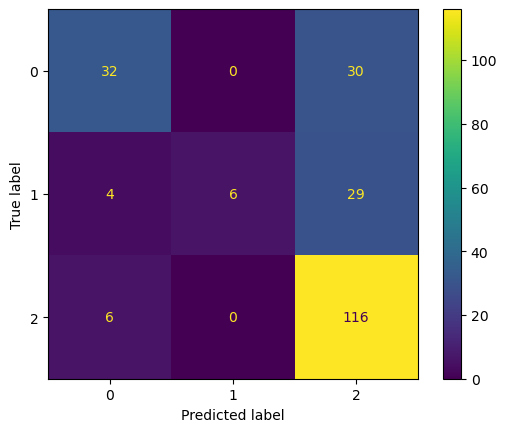

In [241]:
# Let's test the performance on the test set.
y_test_pred = classifier.predict(X_test_tweets)
# Checking performance
cm = confusion_matrix(test_labels, y_test_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()
print(classification_report(test_labels, y_test_pred))

# 4. Extracting topics using LDA

In [242]:
# First let's get another clean split of the data. 
from sklearn.model_selection import train_test_split

# Split test data from training data
train_tweets, test_tweets, train_labels, test_labels = train_test_split(
    all_text, 
    all_labels, 
    test_size=0.2, 
    stratify=all_labels
)

# Split validation data from training data
train_tweets, val_tweets, train_labels, val_labels = train_test_split(
    train_tweets, 
    train_labels, 
    test_size=0.2, 
    stratify=train_labels 
)

print(f'Number of training instances = {len(train_tweets)}')
print(f'Number of validation instances = {len(val_tweets)}')
print(f'Number of test instances = {len(test_tweets)}')


Number of training instances = 710
Number of validation instances = 178
Number of test instances = 223


In [243]:
 # We use the function below for tokenization. Does a number of things, including removing small words, deleting words with special chars,  changing uppercase to lowercase, and more.
def preprocess(text):
    final_results=[]
    for token in simple_preprocess(text) : 
        if token not in STOPWORDS:
            final_results.append(WordNetLemmatizer().lemmatize(token, 'v'))
    return final_results

# Create a list of preprocessed documents
processed = []
for doc in train_tweets:
    processed.append(preprocess(doc))
print(processed)

[['heat', 'yahoo', 'yhoo', 'wall', 'street', 'journal', 'https', 'jvji', 'bia'], ['irish', 'housebuilder', 'cairn', 'home', 'plan', 'london', 'list'], ['lnt', 'increase', 'annual', 'dividend', 'target', 'share', 'share'], ['bpi', 'say', 'caixabank', 'isabel', 'do', 'santos', 'reach', 'agreement', 'angola', 'exposure'], ['take', 'endp', 'long', 'vwap', 'guide'], ['stock', 'resume', 'gain', 'rally', 'record', 'crh', 'tullow', 'climb'], ['rxii', 'tang', 'toxic', 'bring', 'share', 'price', 'let', 'climb', 'little', 'drag'], ['nugt', 'longer', 'term', 'bullish'], ['qihu', 'totally', 'miss', 'jump', 'break', 'test', 'congrats', 'short'], ['wft', 'closng', 'higher'], ['itv', 'share', 'price', 'group', 'mull', 'takeover', 'canada', 'entertainment'], ['glencore', 'chief', 'blame', 'rival', 'overproduction', 'share', 'price', 'fall'], ['starbucks', 'share', 'sbux', 'https', 'jlgrprr'], ['update', 'bp', 'settle', 'oil', 'spill', 'relate', 'claim', 'halliburton', 'transocean'], ['nflx', 'tsla', 'm

In [244]:
from gensim.corpora import Dictionary
# create a dictionary of word<->id key/val pairs.
dictionary = Dictionary(processed) 
print(dictionary)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed]

Dictionary(2303 unique tokens: ['bia', 'heat', 'https', 'journal', 'jvji']...)


In [245]:
# Getting means of thetas

from gensim.matutils import any2sparse
from gensim.models import LdaModel

lda_model =  LdaModel(bow_corpus, 
                      num_topics=10, 
                      id2word=dictionary,                                    
                      passes=10,
                    ) 

def get_tweet_topic_dists(train_tweets, lda_model):
    thetas = []
    for i in range(len(train_tweets)):
        # Get the tweet
        unseen_tweet = train_tweets[i]

        # Preprocess for bag of words:
        bow_vector = dictionary.doc2bow(preprocess(unseen_tweet))

        # Let's get the topic distribution:
        theta_tweet = lda_model[bow_vector]

        thetas.append(theta_tweet)

    return thetas

thetas = get_tweet_topic_dists(train_tweets, lda_model)

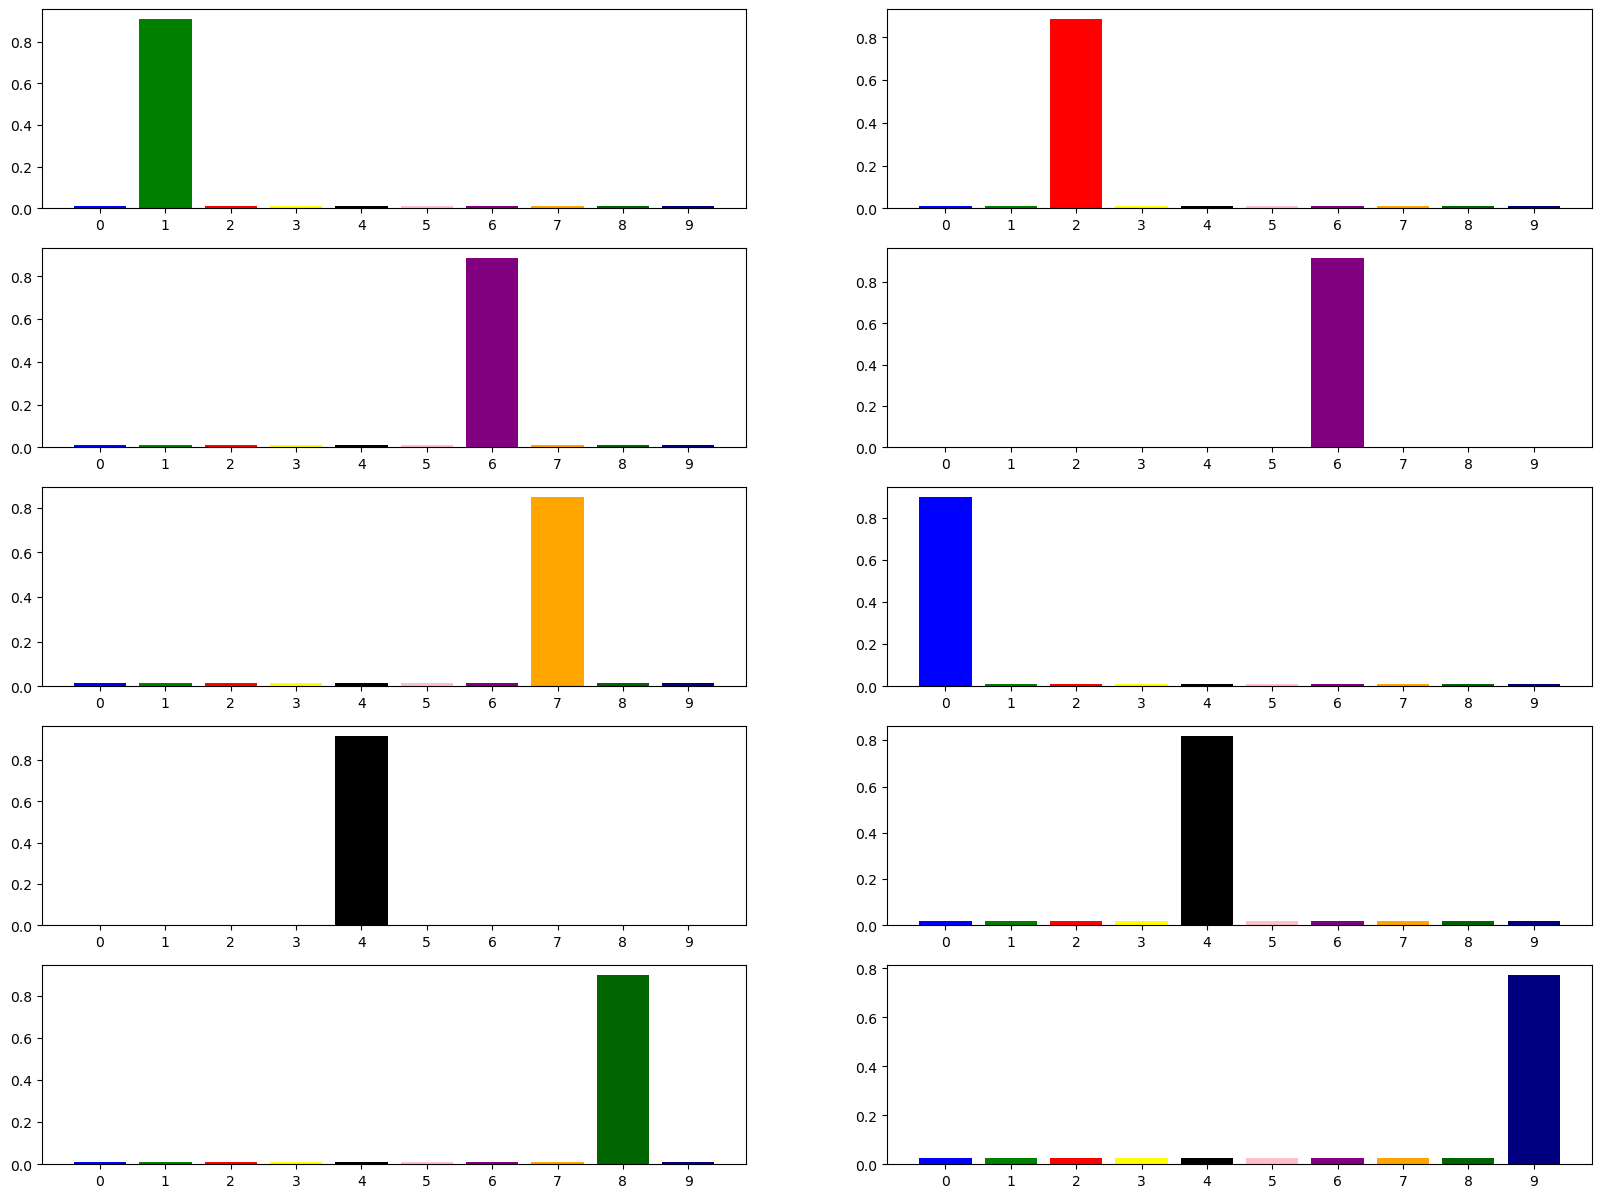

In [246]:

# We will use colours to represent topics.
colours = ['blue', 'green', 'red', 'yellow', 'black', 'pink', 'purple',
           'orange',  'darkgreen',  'navy', 'crimson']

def convert_theta_sparse_to_dense_vector(theta_dist_sparse, num_topics):
    theta_dist = np.zeros(num_topics)  # an empty array
    
    # get active topics
    active_topics_for_dist, probs = map(list, zip(*theta_dist_sparse))
    
    # add to thetas_dist
    for i, topic in enumerate(active_topics_for_dist):
        if topic >= num_topics:
            break
            
        theta_dist[topic] = probs[i]
    
    return theta_dist

# Create barchart
def plot_theta(thetas, i, num_tweets, num_topics):
    plt.subplot(int((num_tweets+1)/2), 2, i+1)
    theta_dist = convert_theta_sparse_to_dense_vector(thetas[i], num_topics)
    plt.bar(x=np.arange(len(theta_dist)), height=theta_dist, color=colours, tick_label=np.arange(num_topics))

plt.figure(figsize=(20,15))

num_tweets = 10
num_topics = 10
counter = 0
for i, theta in enumerate(thetas):
    if (counter < 10):
        plot_theta(thetas, i, num_tweets, num_topics)
        counter +=1
plt.show()

In [247]:
# Merge arrays for later 
arr = train_tweets
arr_2 = train_labels

arrays = [arr,arr_2]
new_arr = np.stack(arrays, axis=1)
print(new_arr[new_arr[:,1] =='1'])

[['Irish housebuilder Cairn Homes plans London listing' '1']
 ['UPDATE 3-BP settles oil spill-related claims with Halliburton, Transocean'
  '1']
 ['Adobe Receives New Rating from Top Analyst $ADBE https://t.co/LJNXPEvHZN'
  '1']
 ['RT @tomhend777 $MU needs to hold here -Broken for now. Needs big flush. Still not technically oversold so now big bounce yet'
  '1']
 ['Philip Morris, BAT Sue Over Law Taking Branding Off Packs' '1']
 ["$XLI Potential intermediate top in an Uptrend on a 60'-15'-4' charts http://stks.co/j1TdF"
  '1']
 ["Tesco closes in on new chairman with Dixons Carphone's John Allan in the frame"
  '1']
 ["Barclays appoints JPMorgan's Paul Compton as new COO" '1']
 ['Shell challenges Exxon dominance with 47 billion-pound bid for BG' '1']
 ['Germanwings disaster will not affect image of budget air travel - easyJet'
  '1']
 ['CompaniesNew Aggreko CEO to reshape business, strip costs' '1']
 ['$AGN and $PYPL under pressure along with the market, however there were bullish opti

In [248]:
# Show numbers till 8 decimal points for debugging.
np.set_printoptions(precision=8)
def get_tweet_mean_topics():
    # Create a matrix where each row corresponds to a label
    mean_thetas = np.zeros((len(['0','1','2']), 10))
    label_arr = ['0','1','2']
    for label in label_arr:
        # call get_tweet_topic_dists
        thetas_t_sparse = get_tweet_topic_dists(train_tweets[new_arr[:,1] ==label], lda_model)
        # convert to a dense vector
        thetas_t = []
        for theta_dist_t_sparse in thetas_t_sparse:
            if not theta_dist_t_sparse:
                continue
            thetas_dist = convert_theta_sparse_to_dense(theta_dist_t_sparse, 10)
            thetas_t.append(thetas_dist)
        # Get the mean theta
        mean_theta_t = np.mean(thetas_t, axis=0)
        mean_thetas[int(label)] = mean_theta_t
        print(mean_thetas[int(label)])
    return mean_thetas
   
mean_arr = get_tweet_mean_topics()

print(mean_arr.shape)

[0.07758644 0.10284001 0.07119656 0.06893546 0.07410486 0.10911272
 0.13732405 0.12754202 0.10616208 0.10519311]
[0.06596619 0.09934751 0.08161045 0.06527278 0.06861268 0.10612496
 0.12863206 0.13542022 0.11799317 0.11556057]
[0.05368419 0.0915401  0.08676051 0.09537613 0.08560486 0.12062449
 0.11516092 0.12610558 0.12081624 0.0842266 ]
(3, 10)


[0.07758649 0.10284007 0.07119539 0.06893547 0.07410487 0.10911067
 0.13732796 0.12754137 0.10616206 0.10519296]
[0.0659662  0.0993472  0.08161044 0.06527212 0.06861275 0.10612477
 0.12863265 0.1354211  0.11799162 0.11556176]
[0.0536843  0.09136525 0.08676138 0.0978784  0.08560512 0.11890197
 0.11515904 0.1261061  0.12021147 0.08422658]


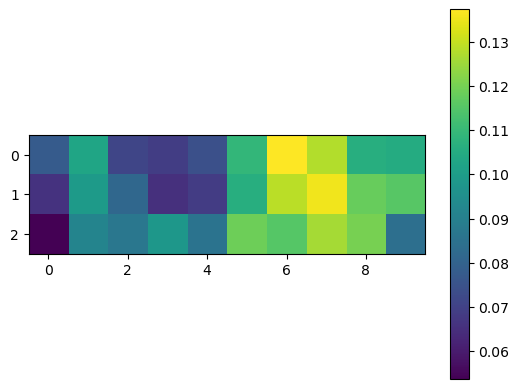

In [249]:
def plot_tweet_topic_matrix():
    # Get mean tweet topics dists
    mean_thetas = get_tweet_mean_topics()
    # Let's show a heatmap to see which topics occur the most for different labels
    plt.imshow(mean_thetas)
    plt.colorbar()
    plt.show()
plot_tweet_topic_matrix()

In [250]:
# For each topic, let's show the words occuring in that topic, so we can identify it.
for topic_id, topic in lda_model.print_topics(-1):
    print("Topic ID: {} \nAssociated Words:\n {}".format(topic_id, topic ))
    print("\n")

Topic ID: 0 
Associated Words:
 0.011*"break" + 0.011*"stks" + 0.011*"http" + 0.009*"short" + 0.007*"dividend" + 0.007*"fear" + 0.007*"get" + 0.006*"today" + 0.006*"update" + 0.006*"ftse"


Topic ID: 1 
Associated Words:
 0.013*"https" + 0.011*"stks" + 0.011*"http" + 0.008*"bullish" + 0.008*"fb" + 0.007*"buy" + 0.006*"ceo" + 0.006*"spy" + 0.006*"end" + 0.006*"charter"


Topic ID: 2 
Associated Words:
 0.022*"http" + 0.021*"stks" + 0.011*"look" + 0.009*"stock" + 0.009*"like" + 0.008*"https" + 0.007*"support" + 0.007*"berkshire" + 0.005*"stake" + 0.005*"new"


Topic ID: 3 
Associated Words:
 0.013*"buy" + 0.011*"aapl" + 0.009*"long" + 0.007*"bounce" + 0.007*"share" + 0.007*"profit" + 0.006*"business" + 0.006*"run" + 0.006*"sales" + 0.006*"like"


Topic ID: 4 
Associated Words:
 0.012*"price" + 0.009*"http" + 0.009*"stks" + 0.009*"dividend" + 0.006*"long" + 0.006*"chart" + 0.006*"short" + 0.006*"share" + 0.006*"cost" + 0.006*"go"


Topic ID: 5 
Associated Words:
 0.024*"http" + 0.023*"stk